<a href="https://colab.research.google.com/github/Pouyaaskari/object-detection/blob/master/Bounding_box_regression_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!git clone https://github.com/Alireza-Akhavan/object-detection-notebooks.git

Cloning into 'object-detection-notebooks'...
remote: Enumerating objects: 2083, done.
remote: Counting objects: 100% (2083/2083), done.
remote: Compressing objects: 100% (2078/2078), done.
remote: Total 2083 (delta 9), reused 2069 (delta 2), pack-reused 0
Receiving objects: 100% (2083/2083), 26.78 MiB | 27.23 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [31]:
from tensorflow import keras
from keras.layers import Flatten,Dense,Input
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import mimetypes
import argparse
import cv2
import os

In [9]:
path="/content/object-detection-notebooks/dataset"

path1=os.path.sep.join([path,"images"])
path2=os.path.sep.join([path,"airplanes.csv"])

In [10]:
rows = open(annotation).read().strip().split("\n")
print(rows)

['image_0001.jpg,49,30,349,137', 'image_0002.jpg,59,35,342,153', 'image_0003.jpg,47,36,331,135', 'image_0004.jpg,47,24,342,141', 'image_0005.jpg,48,18,339,146', 'image_0006.jpg,48,24,344,126', 'image_0007.jpg,49,23,344,122', 'image_0008.jpg,51,29,344,119', 'image_0009.jpg,50,29,344,137', 'image_0010.jpg,55,32,335,106', 'image_0011.jpg,58,35,344,130', 'image_0012.jpg,49,25,344,122', 'image_0013.jpg,48,31,344,146', 'image_0014.jpg,55,37,349,121', 'image_0015.jpg,61,39,353,163', 'image_0016.jpg,59,54,327,137', 'image_0017.jpg,62,37,347,143', 'image_0018.jpg,57,33,348,147', 'image_0019.jpg,51,33,341,146', 'image_0020.jpg,45,31,345,165', 'image_0021.jpg,48,28,347,129', 'image_0022.jpg,49,30,344,130', 'image_0023.jpg,50,23,341,121', 'image_0024.jpg,48,25,344,106', 'image_0025.jpg,56,31,342,140', 'image_0026.jpg,59,30,337,127', 'image_0027.jpg,53,25,348,123', 'image_0028.jpg,54,29,346,114', 'image_0029.jpg,56,29,348,119', 'image_0030.jpg,47,15,354,161', 'image_0031.jpg,58,41,347,197', 'image_

In [11]:
data = []
targets = []
filenames = []

In [12]:
for row in rows:
  (filename, startX, startY, endX, endY) = row.split(",")
  imagePath = os.path.sep.join([path1, filename])
  image = cv2.imread(imagePath)
  (h, w) = image.shape[:2]
  startX = float(startX) / w
  startY = float(startY) / h
  endX = float(endX) / w
  endY = float(endY) / h

  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image)
  data.append(image)
  targets.append((startX, startY, endX, endY))
  filenames.append(filename)

In [13]:
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

In [14]:
split=train_test_split(data, targets, filenames, test_size=0.10, random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

In [23]:
vgg =VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

58900480/58889256 [==============================] - 0s 0us/step


In [24]:
model=Sequential()
model.add(vgg)
model.add(Flatten())
model.add( Dense(128, activation="relu"))
model.add( Dense(64, activation="relu"))
model.add( Dense(32, activation="relu"))
model.add( Dense(4, activation="sigmoid"))

In [25]:
vgg.trainable=False

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 17,936,548
Trainable params: 3,221,860
Non-trainable params: 14,714,688
____________________________________

In [27]:
opt = Adam(lr=1e-4)
model.compile(loss="mse", optimizer=opt)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [28]:
history=model.fit(trainImages, trainTargets,
validation_data=(testImages, testTargets),
batch_size=32,
epochs=25,
verbose=1)

Epoch 1/25
23/23 [==============================] - 57s 330ms/step - loss: 0.0572 - val_loss: 0.0017
Epoch 2/25
23/23 [==============================] - 3s 145ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 3/25
23/23 [==============================] - 3s 145ms/step - loss: 9.3520e-04 - val_loss: 6.1430e-04
Epoch 4/25
23/23 [==============================] - 3s 145ms/step - loss: 7.6437e-04 - val_loss: 5.3863e-04
Epoch 5/25
23/23 [==============================] - 3s 145ms/step - loss: 0.0011 - val_loss: 5.3045e-04
Epoch 6/25
23/23 [==============================] - 3s 144ms/step - loss: 5.3904e-04 - val_loss: 4.9437e-04
Epoch 7/25
23/23 [==============================] - 3s 142ms/step - loss: 5.5023e-04 - val_loss: 5.1219e-04
Epoch 8/25
23/23 [==============================] - 3s 142ms/step - loss: 5.5657e-04 - val_loss: 5.0325e-04
Epoch 9/25
23/23 [==============================] - 3s 141ms/step - loss: 4.6410e-04 - val_loss: 4.8099e-04
Epoch 10/25
23/23 [============================

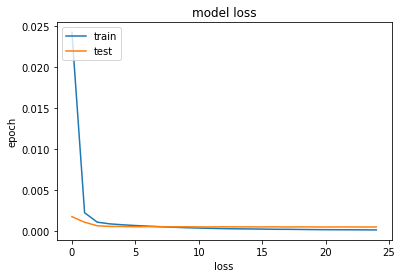

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('epoch')
plt.xlabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
model.save("localization.h5", save_format="h5")

In [32]:
def inference(imagepath):
  image=load_img(imagepath,target_size=(224,224))
  image=img_to_array(image)/255.0
  image=np.expand_dims(image,axis=0)

  prediction=model.predict(image)[0]
  return prediction

In [35]:
def draw_box(img,prediction):
  image=np.copy(img)
  (startX, startY, endX, endY) = prediction
  (h, w) = image.shape[:2]

  startX = int(startX * w)
  startY = int(startY * h)
  endX = int(endX * w)
  endY = int(endY * h)

  cv2.rectangle(image, (startX, startY), (endX, endY),(255, 0, 0), 2)
  return image

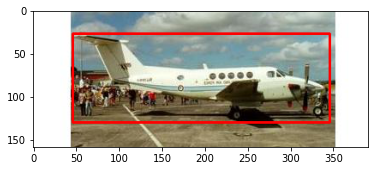

In [36]:
image_path="/content/object-detection-notebooks/dataset/images/image_0021.jpg"
image=plt.imread(image_path)
prediction=inference(image_path)
bbox=draw_box(image,prediction)

plt.imshow(bbox)